# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final project: Structured Streaming** </center>
---

**Date**: 23 de Noviembre, 2025

**Student Name**: Aura Melina Gutierrez Jimenez

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Structured Streaming") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e783dfa0-fed7-4f83-8608-a23f8d69a012;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

In [2]:
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "chicago-traffic-telemetry") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## Producer

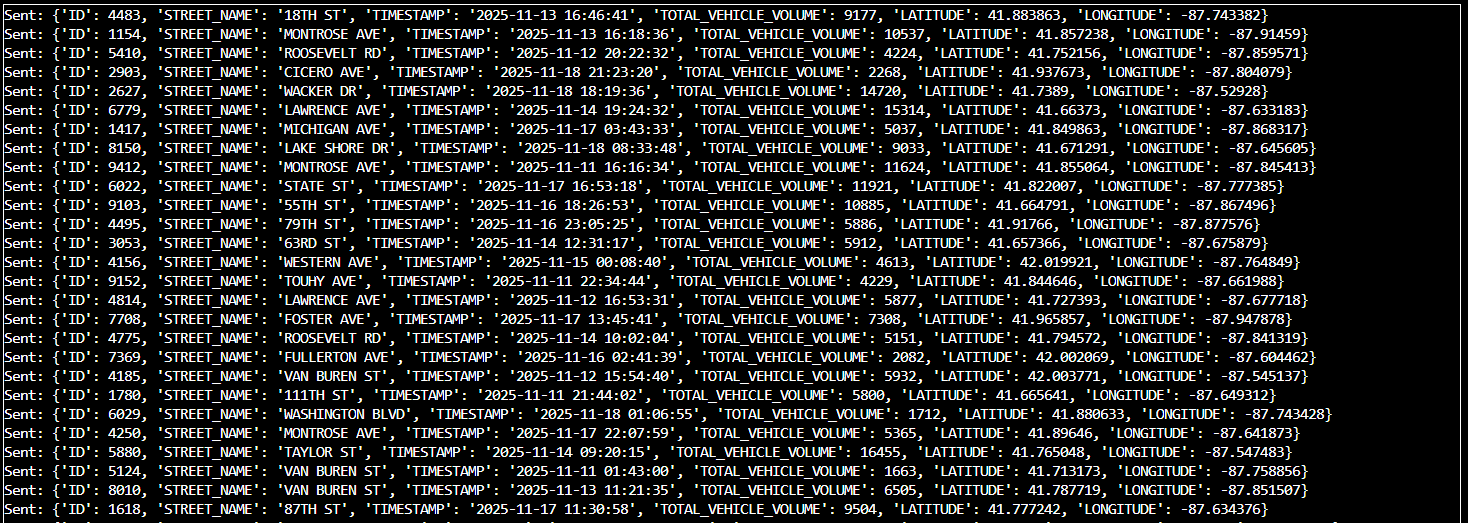

## Consumer

In [3]:
from pyspark.sql.types import StructField
from pyspark.sql.functions import from_json, col
from auragutierrez.spark_utils import SparkUtils

# Step 1: Cast Kafka value to string
traffic_telemetry_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

# Step 2: Define schema for traffic data (same 6 columns as producer)
traffic_schema_columns = [
    ("ID", "int"),
    ("STREET_NAME", "string"),
    ("TIMESTAMP", "timestamp"),
    ("TOTAL_VEHICLE_VOLUME", "int"),
    ("LATITUDE", "double"),
    ("LONGITUDE", "double")
]

# Generate schema using SparkUtils
traffic_schema = SparkUtils.generate_schema(traffic_schema_columns)

traffic_extracted_df = traffic_telemetry_df.withColumn("telemetry",from_json(col("value_str"), traffic_schema))

traffic_extracted_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- ID: integer (nullable = true)
 |    |-- STREET_NAME: string (nullable = true)
 |    |-- TIMESTAMP: timestamp (nullable = true)
 |    |-- TOTAL_VEHICLE_VOLUME: integer (nullable = true)
 |    |-- LATITUDE: double (nullable = true)
 |    |-- LONGITUDE: double (nullable = true)



In [4]:
# Extract the year, monht, and day from the timestamp column
from pyspark.sql.functions import year, month, day

traffic_extracted_time_df = traffic_extracted_df.withColumn("year", year(traffic_extracted_df.telemetry.timestamp)) \
                                      .withColumn("month", month(traffic_extracted_df.telemetry.timestamp)) \
                                      .withColumn("day", day(traffic_extracted_df.telemetry.timestamp))

traffic_extracted_time_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- ID: integer (nullable = true)
 |    |-- STREET_NAME: string (nullable = true)
 |    |-- TIMESTAMP: timestamp (nullable = true)
 |    |-- TOTAL_VEHICLE_VOLUME: integer (nullable = true)
 |    |-- LATITUDE: double (nullable = true)
 |    |-- LONGITUDE: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



In [5]:
# Flatten telemetry struct to have columns at root level
traffic_stream = traffic_extracted_time_df.select(col("telemetry.*"),col("year"),col("month"),col("day"))

## Transformations and Actions

In [6]:
from pyspark.sql.functions import upper, trim, hour, dayofweek, when, lit, avg

# Step 1: Clean data
df_clean = traffic_stream.filter(
    (col("TOTAL_VEHICLE_VOLUME").isNotNull()) &
    (col("TOTAL_VEHICLE_VOLUME") > 0) &
    (col("LATITUDE").isNotNull()) &
    (col("TIMESTAMP").isNotNull())
)

# Step 2: Feature engineering
df_features = df_clean.withColumn(
    "STREET_NAME_CLEAN",
    upper(trim(col("STREET_NAME")))
).withColumn(
    "HOUR_OF_DAY",
    hour(col("TIMESTAMP"))
).withColumn(
    "DAY_TYPE",
    when(dayofweek(col("TIMESTAMP")).isin(1, 7), lit("Weekend"))
    .otherwise(lit("Weekday"))
)

df_features.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- STREET_NAME: string (nullable = true)
 |-- TIMESTAMP: timestamp (nullable = true)
 |-- TOTAL_VEHICLE_VOLUME: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- STREET_NAME_CLEAN: string (nullable = true)
 |-- HOUR_OF_DAY: integer (nullable = true)
 |-- DAY_TYPE: string (nullable = false)



In [7]:
# Aggregate by street, location, day type, and hour
df_aggregated = df_features.groupBy(
    col("STREET_NAME_CLEAN"),
    col("LATITUDE"),
    col("LONGITUDE"),
    col("DAY_TYPE"),
    col("HOUR_OF_DAY")
).agg(
    avg(col("TOTAL_VEHICLE_VOLUME")).alias("AVG_STREET_VOLUME"),
    avg(col("TOTAL_VEHICLE_VOLUME")).alias("AVG_HOURLY_VOLUME_FOR_TYPE")
)

# Calculate congestion metrics
df_traffic_insights = df_aggregated.withColumn(
    "AVG_CONGESTION_INDEX_BY_HOUR",
    col("AVG_HOURLY_VOLUME_FOR_TYPE") / col("AVG_STREET_VOLUME")
).withColumn(
    "CONGESTION_LEVEL",
    when(col("AVG_CONGESTION_INDEX_BY_HOUR") >= 1.5, lit("High Congestion"))
    .when((col("AVG_CONGESTION_INDEX_BY_HOUR") >= 1.0) & 
          (col("AVG_CONGESTION_INDEX_BY_HOUR") < 1.5), lit("Moderate"))
    .otherwise(lit("Normal/Low"))
)

#df_traffic_insights.printSchema()

## Persistence Data

In [20]:
!cd .. ; cd .. ; ls ; pwd ; mkdir data/traffic_output

data	  final_project  jars  lib   models
examples  img		 labs  libs  vg_checkpoint
/opt/spark/work-dir


In [8]:
query_files = df_features.writeStream \
    .outputMode("append") \
    .trigger(processingTime="30 seconds") \
    .partitionBy("DAY_TYPE") \
    .format("parquet") \
    .option("path", "/opt/spark/work-dir/data/traffic_output/") \
    .option("checkpointLocation", "/opt/spark/work-dir/traffic_checkpoint_final") \
    .start()

25/11/18 00:36:04 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
                                                                                

In [10]:
query_files.stop()
sc.stop()

## Power BI Dashboard

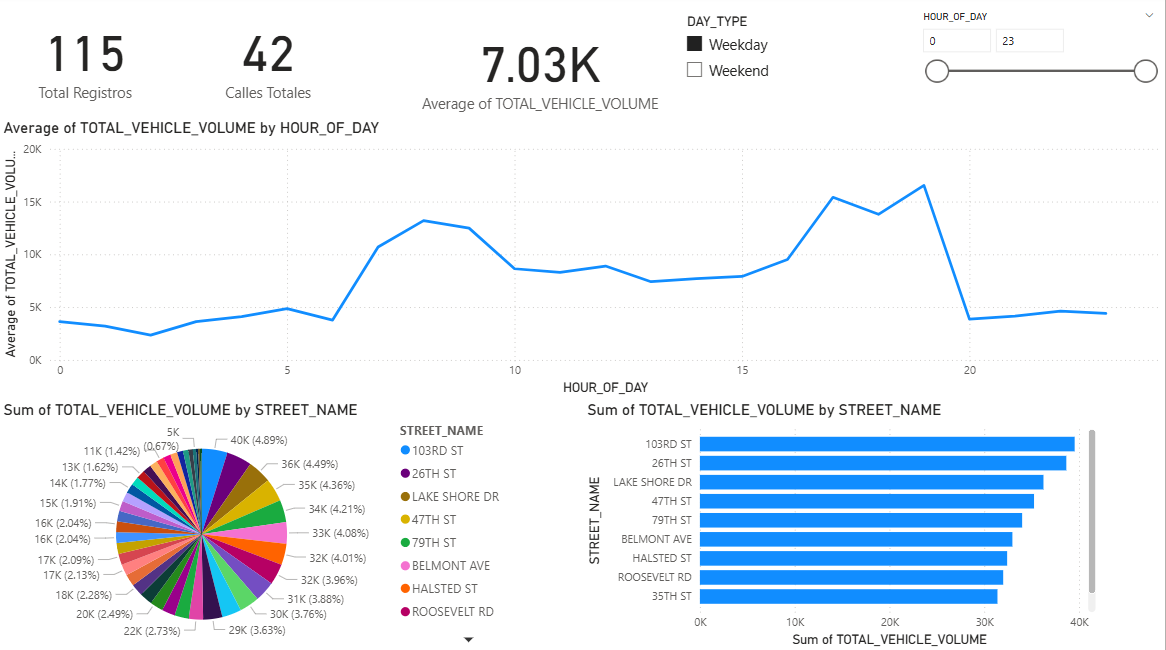